In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [17]:
x = np.random.normal(0,1,100000)

(array([3.4000e+01, 5.3100e+02, 4.2570e+03, 1.6458e+04, 3.1029e+04,
        2.9660e+04, 1.4252e+04, 3.3690e+03, 3.8400e+02, 2.6000e+01]),
 array([-4.22386274, -3.36598981, -2.50811687, -1.65024393, -0.792371  ,
         0.06550194,  0.92337487,  1.78124781,  2.63912075,  3.49699368,
         4.35486662]),
 <a list of 10 Patch objects>)

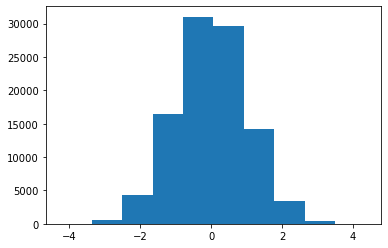

In [18]:
plt.hist(x)

In [19]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [20]:
'''
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput
'''

'\ndef myloss(y_true, y_pred, alpha = 0.):\n    #alpha determines the amount of decorrelation; 0 means no decorrelation.\n    \n    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.\n    #g(x) = y_pred[:,0]\n    #f(g(x)) = y_pred[:,1]\n    #h(x) = y_pred[:,2]\n    #h(g(x)) = y_pred[:,3]\n    \n    myoutput =  mse(y_true[:,0],y_pred[:,1])                 - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2]))                 - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))\n    return myoutput\n'

In [21]:
'''
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
#autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []
preds += [encoder.predict(np.linspace(-4,4,10))]

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)))

    #y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    #print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True
'''

'\n#setup the model\n\nmyinput = Input(shape=(1,))\nencoded = Dense(5, activation=\'elu\')(myinput)\nencoded = Dense(5, activation=\'elu\')(encoded)\nencoded = Dense(1, activation=\'linear\')(encoded)\n\nencoder = Model(myinput, encoded)\nencoder2 = encoder(encoder(myinput))\nautoencoder = Model(myinput, encoder2)\n\ncombinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))\n\nmyinput_classify = Input(shape=(1,))\nmyclassifier = Dense(128, activation=\'elu\')(myinput_classify)\nmyclassifier = Dense(64, activation=\'elu\')(myclassifier)\nmyclassifier = Dense(1, activation=\'sigmoid\')(myclassifier)\nmyclassifier_model = Model(myinput_classify, myclassifier)\nmyclassifier_input = myclassifier_model(myinput)\nmyclassifier_encoded = myclassifier_model(encoded)\n\ncombinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))\n\n#First, pretrain the autoencoder:\n#autoencoder.compile(optimizer=\'adam\', loss=\'mse

In [22]:
'''
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)
'''

'\nfor i in range(len(preds)):\n    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))\n    pass\nplt.legend(frameon=False)\n'

In [23]:
#mypreds = combinedModel_classifier.predict(x)

In [24]:
'''
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("function value")
plt.legend(frameon=False)
'''

'\nplt.scatter(x,mypreds[:,0],label="Encoder")\nplt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")\nplt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=\':\',color="gray")\nplt.xlabel("x")\nplt.ylabel("function value")\nplt.legend(frameon=False)\n'

In [25]:
x2 = np.random.normal(0,1,100000)

In [26]:
X = np.c_[x,x2]

In [27]:
def myloss2d(y_true, y_pred, alpha = 0.1):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [28]:
#setup the model

myinput_2d = Input(shape=(2,))
encoded_2d = Dense(5, activation='elu')(myinput_2d)
encoded_2d = Dense(5, activation='elu')(encoded_2d)
encoded_2d = Dense(2, activation='linear')(encoded_2d)

encoder_2d = Model(myinput_2d, encoded_2d)
encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
autoencoder_2d = Model(myinput_2d, encoder2_2d)

combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

myinput_classify_2d = Input(shape=(2,))
myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

preds = []
preds += [encoder_2d.predict(X)]

num_iters = 20

for i in range(num_iters):
    print("on i=",i)
    #Now, train the classifier
    encoded_x_2d = encoder_2d.predict(X)
    myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))
        
    #Now, update the autoencoder
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = False

    combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
    combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))
    
    autoencoder_2d.compile(optimizer='adam', loss='mse')
    autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))
    
    preds += [encoder_2d.predict(X)]
    
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = True

on i= 0
100/100 [==============================] - 1s 10ms/step - loss: -1.8081
Epoch 1/5
100/100 [==============================] - 0s 2ms/step - loss: 2.0170
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.9032
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5025
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1928
on i= 1
100/100 [==============================] - 1s 10ms/step - loss: -1.4236
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.6436
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1345
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0958
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0836
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0744
on i= 2
100/100 [=======================

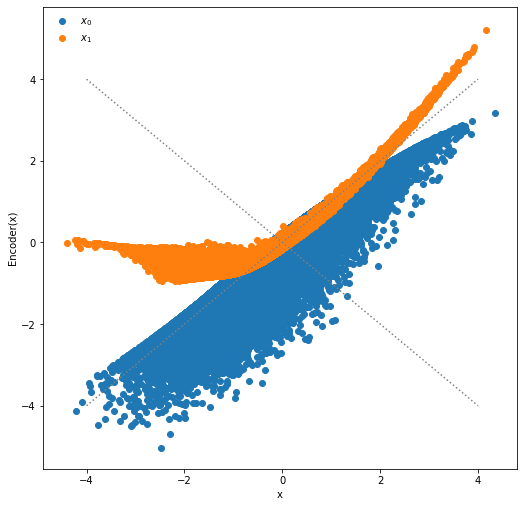

In [29]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,0],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,1],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [30]:
mypreds = combinedModel_classifier_2d.predict(X)

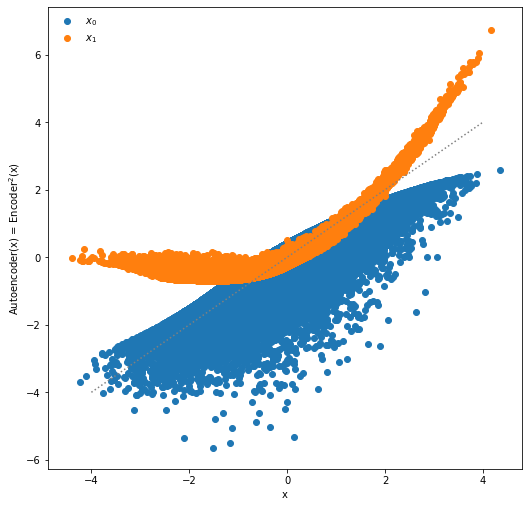

In [31]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

on k= 0
on i= 0
100/100 [==============================] - 1s 12ms/step - loss: -1.4962
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.9655
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.2628
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1051
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0749
on i= 1
100/100 [==============================] - 2s 17ms/step - loss: -0.4201
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.4155
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0771
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0568
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0513
on i= 2
100/100 [===============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 11
on i= 0
100/100 [==============================] - 1s 10ms/step - loss: -1.3836
Epoch 1/5
100/100 [==============================] - 0s 5ms/step - loss: 0.7959
Epoch 2/5
100/100 [==============================] - 0s 4ms/step - loss: 0.3244
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1286
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0873
on i= 1
100/100 [==============================] - 1s 11ms/step - loss: -1.7461
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.7095
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0791
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0470
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 12
on i= 0
100/100 [==============================] - 1s 9ms/step - loss: -1.4887
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.6217
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0790
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0651
on i= 1
100/100 [==============================] - 1s 10ms/step - loss: -1.7819
Epoch 1/5
100/100 [==============================] - 0s 2ms/step - loss: 0.8500
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0700
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0584
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0529
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0475
on i= 2
100/100 [===============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 13
on i= 0
100/100 [==============================] - 1s 13ms/step - loss: -1.3681
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.9820
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.2278
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 4/5
100/100 [==============================] - 0s 4ms/step - loss: 0.0713
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0668
on i= 1
100/100 [==============================] - 1s 9ms/step - loss: -0.9017
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.8929
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1012
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0562
on i= 2
100/100 [===============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 14
on i= 0
100/100 [==============================] - 1s 10ms/step - loss: -2.0312
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 1.1660
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.4757
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1892
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1192
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1051
on i= 1
100/100 [==============================] - 1s 11ms/step - loss: -1.6843
Epoch 1/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5955
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0923
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0863
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0798
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 15
on i= 0
100/100 [==============================] - 1s 12ms/step - loss: -1.8751
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 2.6428
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.9049
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.6206
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5287
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.3859
on i= 1
100/100 [==============================] - 1s 11ms/step - loss: -1.4994
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 1.0079
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1681
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1224
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1112
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1034
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 16
on i= 0
100/100 [==============================] - 1s 10ms/step - loss: -2.9970
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 4.3630
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 1.5695
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.8591
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.6169
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.5272
on i= 1
100/100 [==============================] - 1s 11ms/step - loss: -2.4538
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 2.4926
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.6248
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.4577
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.3648
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.2562
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 17
on i= 0
100/100 [==============================] - 1s 10ms/step - loss: -0.9230
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.7686
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.4232
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0658
on i= 1
100/100 [==============================] - 1s 12ms/step - loss: -0.3234
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.2237
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0294
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 18
on i= 0
100/100 [==============================] - 1s 13ms/step - loss: -2.1063
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.9510
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.3384
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1436
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.1120
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0945
on i= 1
100/100 [==============================] - 1s 10ms/step - loss: -1.7357
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.2293
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0770
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0540
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0471
on i= 2
100/100 [==============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


on k= 19
on i= 0
100/100 [==============================] - 1s 15ms/step - loss: 0.3720
Epoch 1/5
100/100 [==============================] - 0s 4ms/step - loss: 0.6120
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.1046
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0758
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0595
on i= 1
100/100 [==============================] - 1s 11ms/step - loss: -0.2278
Epoch 1/5
100/100 [==============================] - 0s 3ms/step - loss: 0.7555
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0867
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0490
on i= 2
100/100 [===============

/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


why is this growing? 100000 100000


/usr/common/software/tensorflow/intel-tensorflow/2.2.0-py37/lib/python3.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


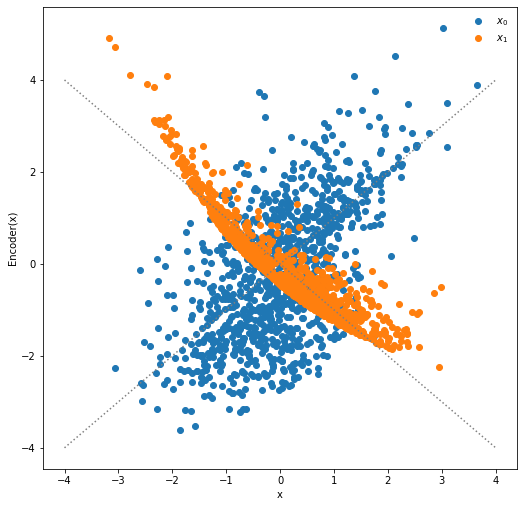

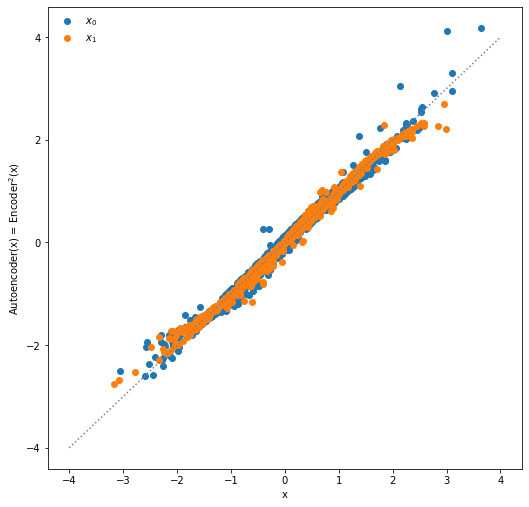

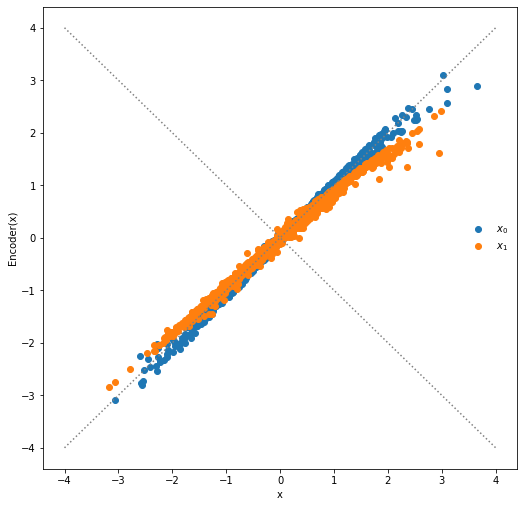

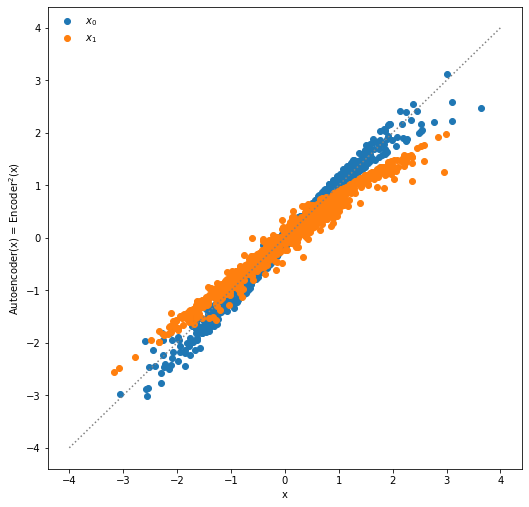

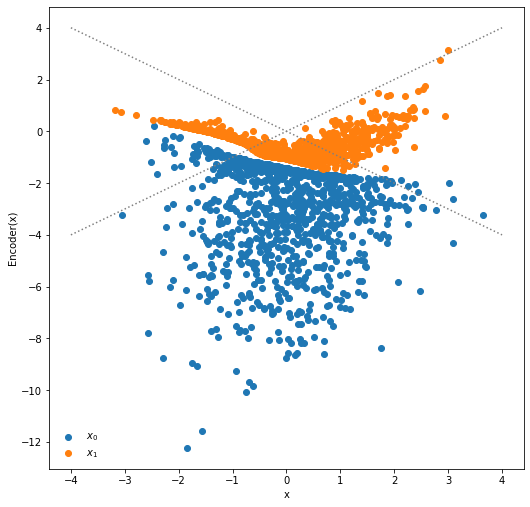

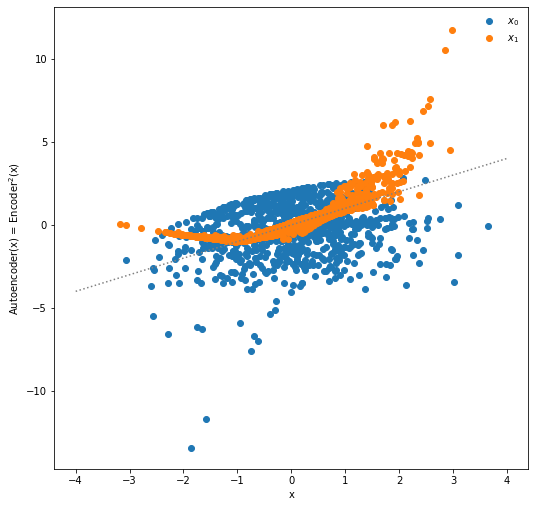

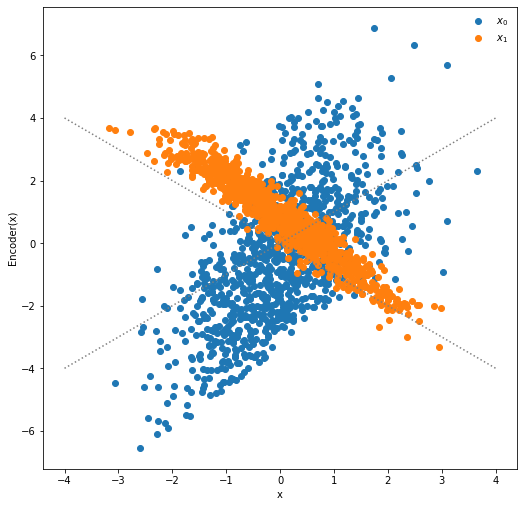

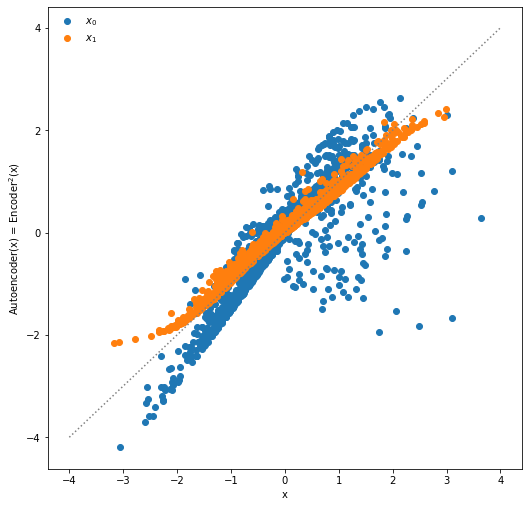

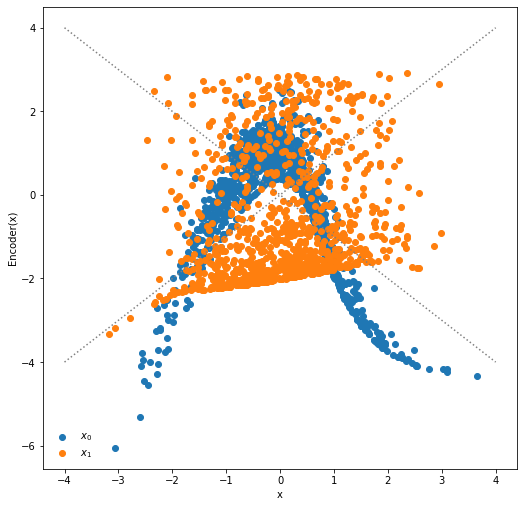

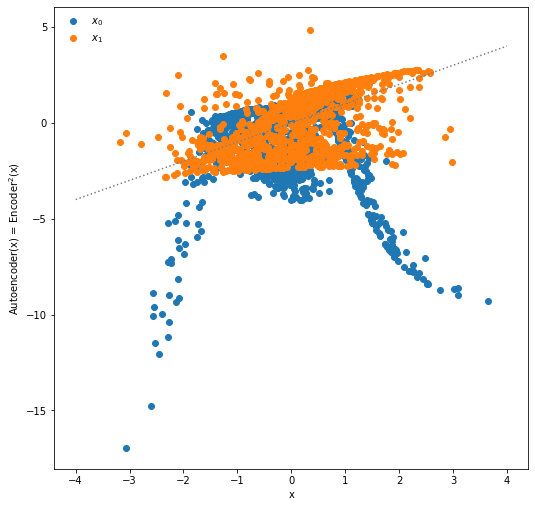

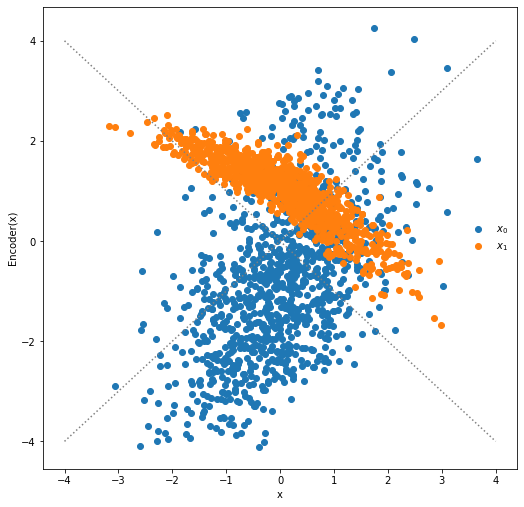

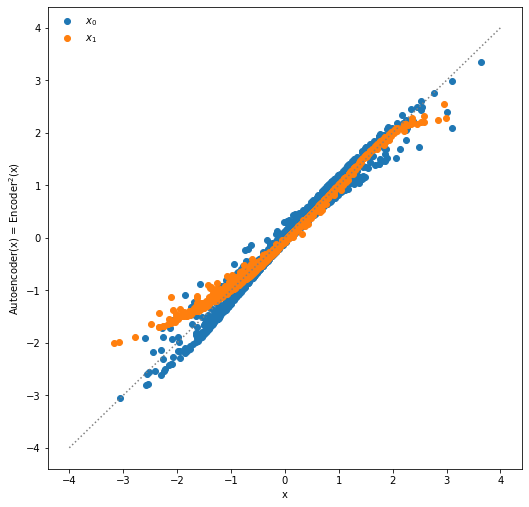

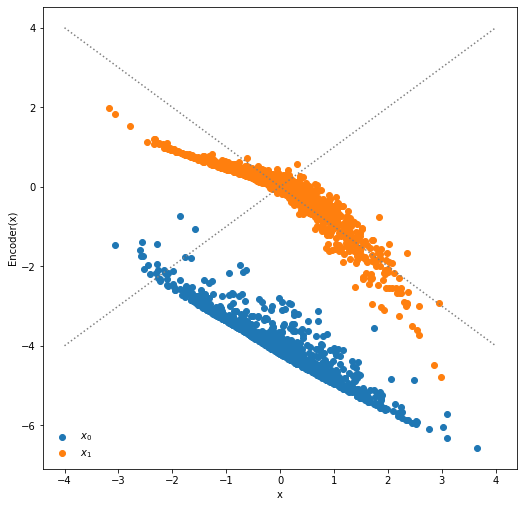

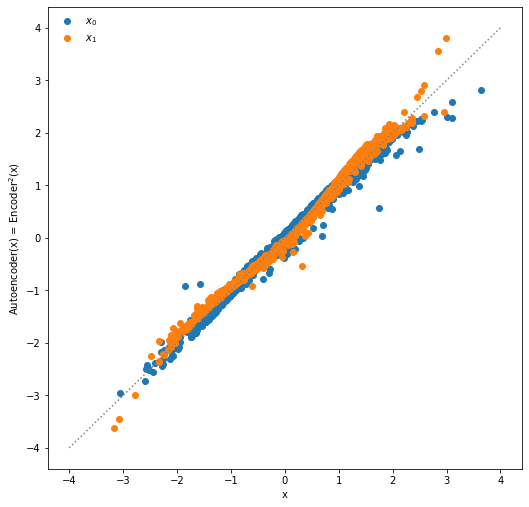

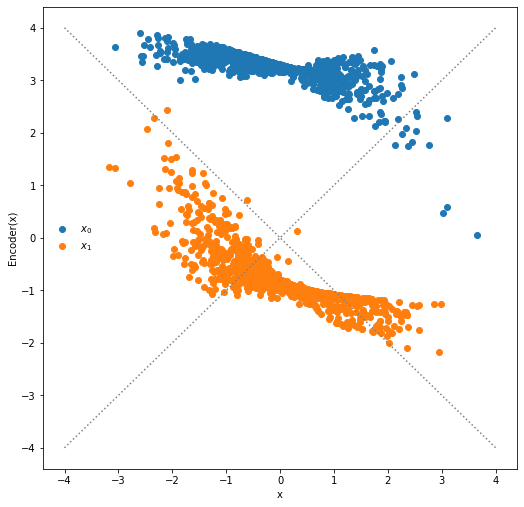

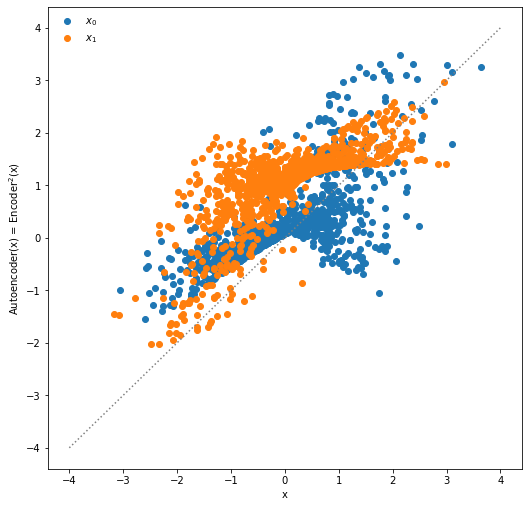

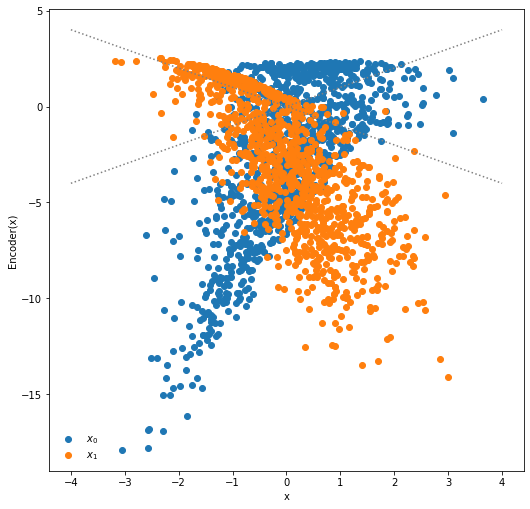

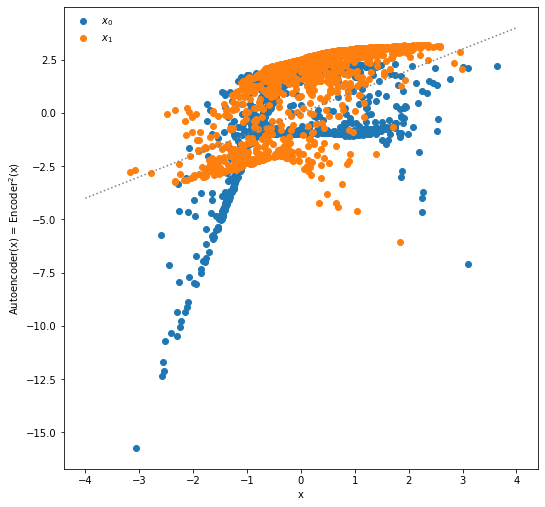

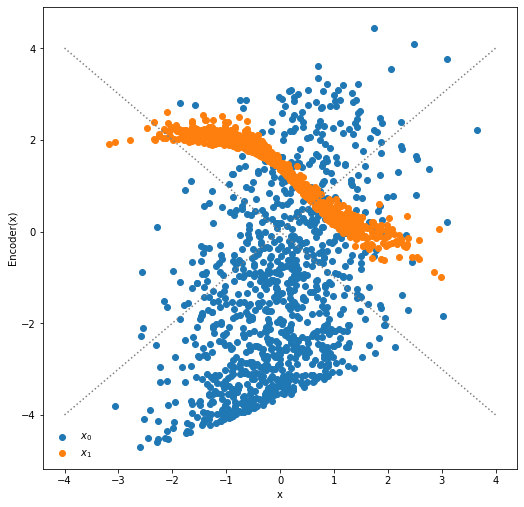

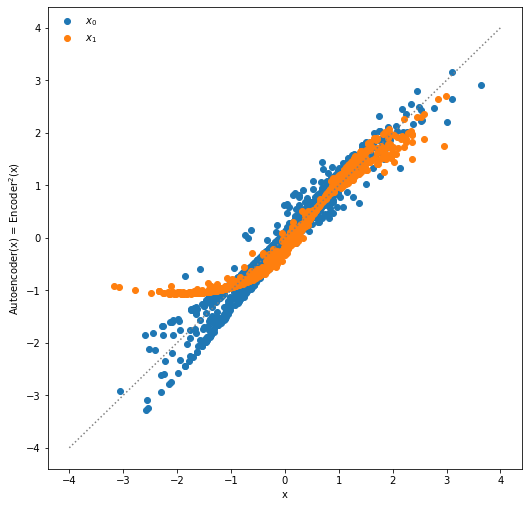

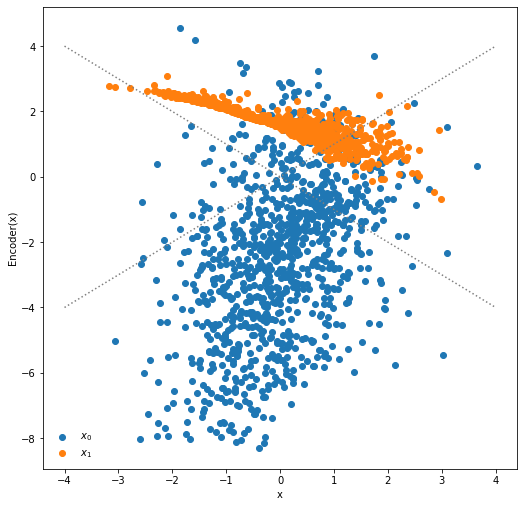

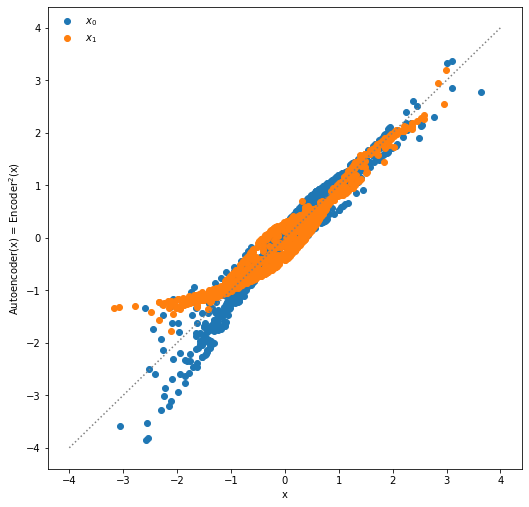

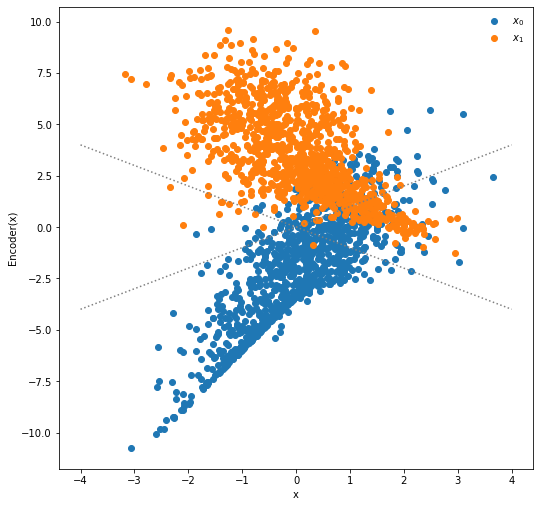

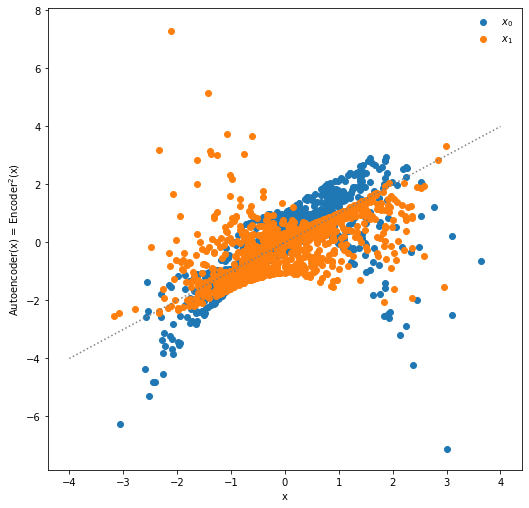

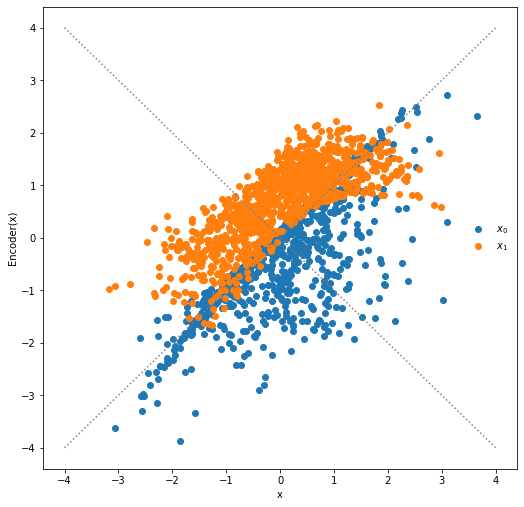

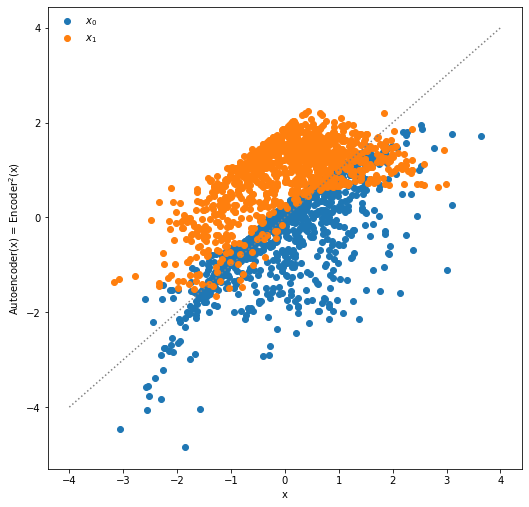

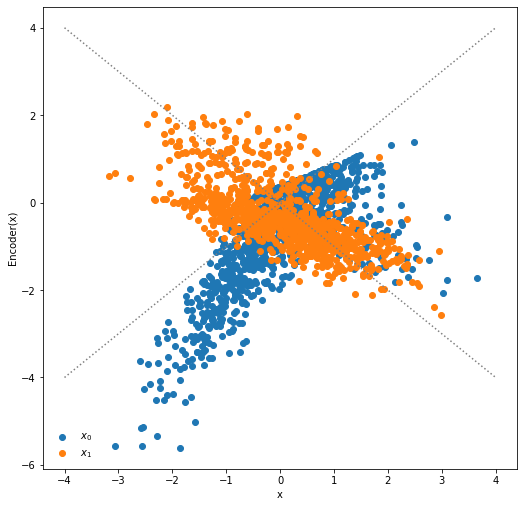

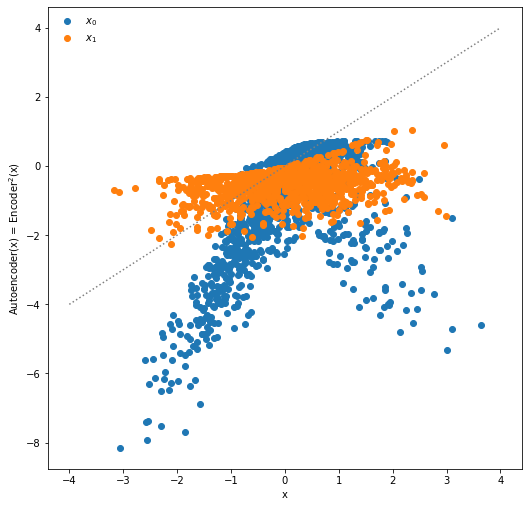

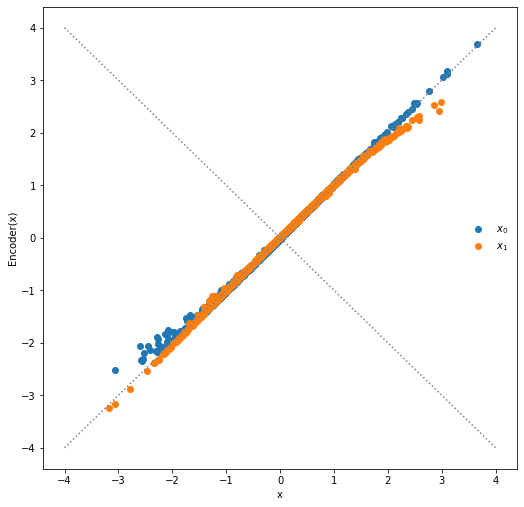

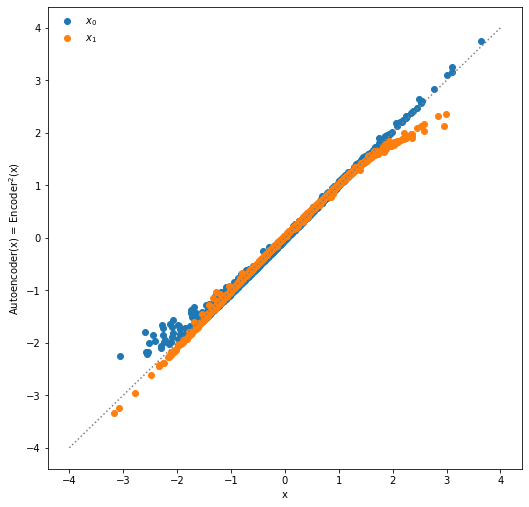

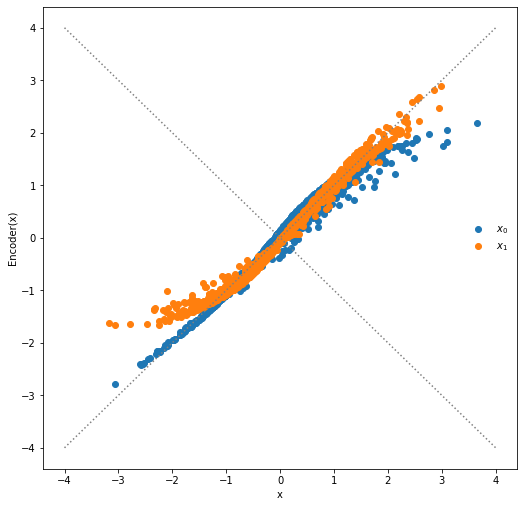

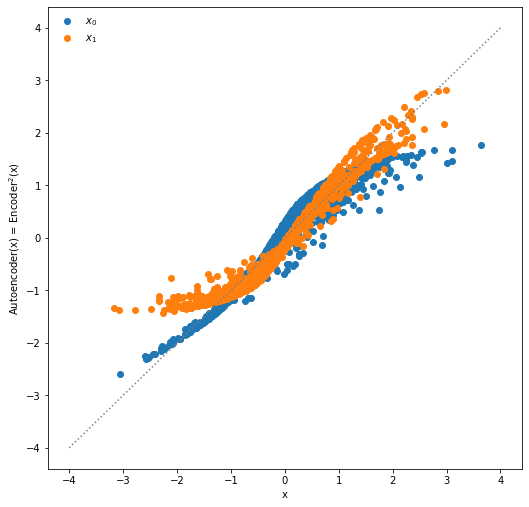

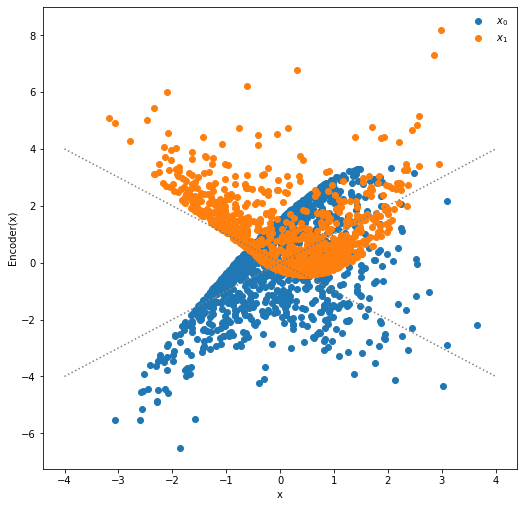

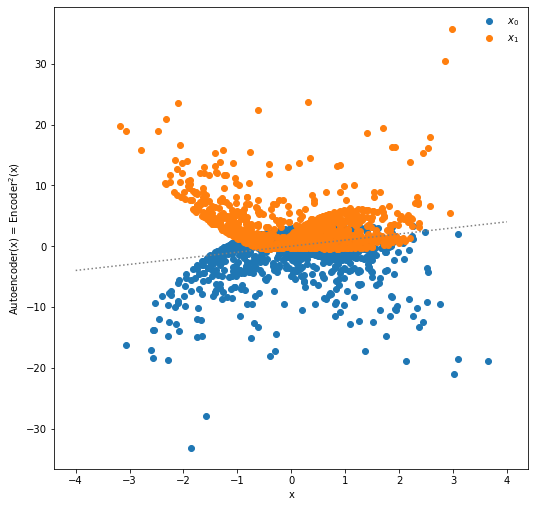

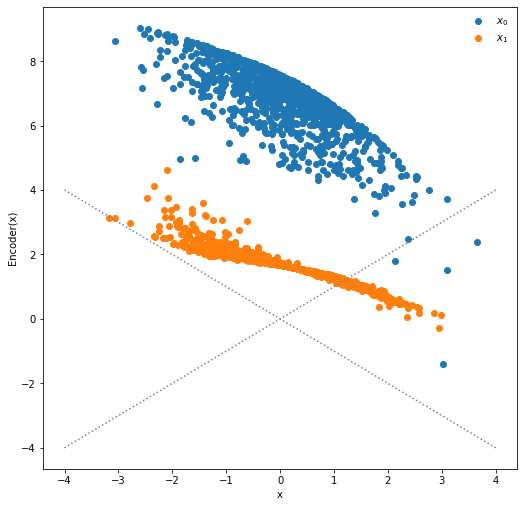

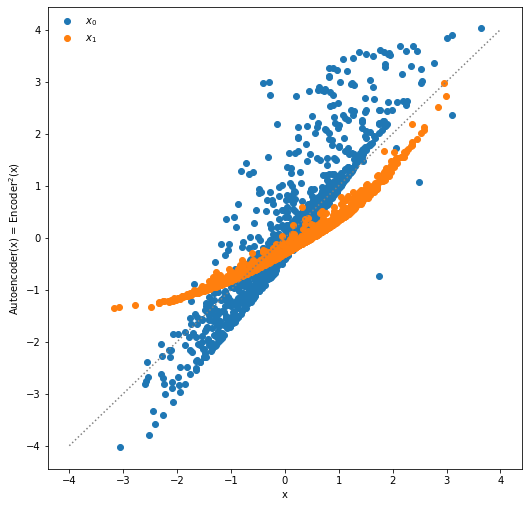

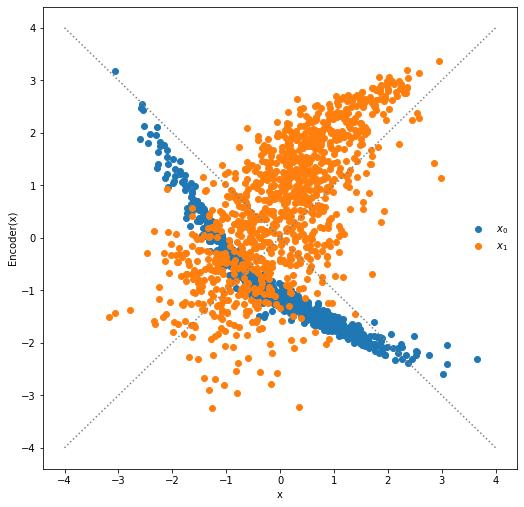

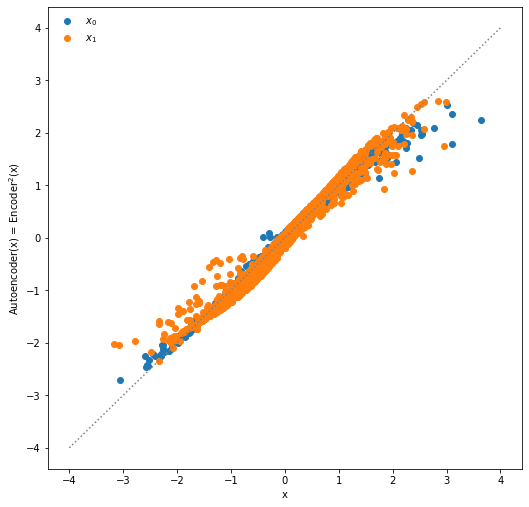

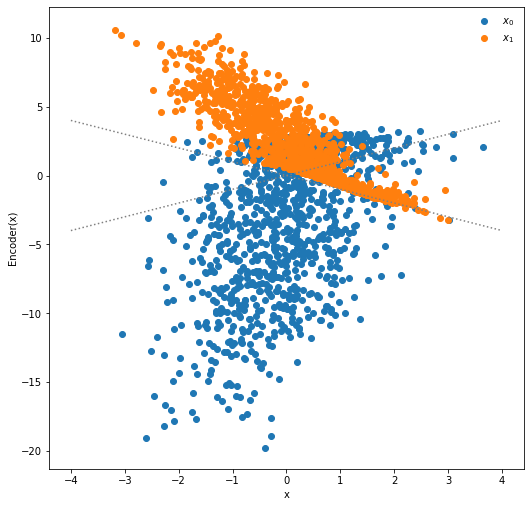

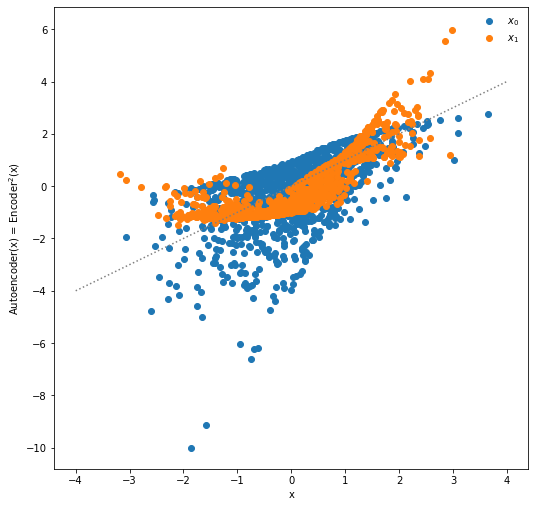

In [32]:
for k in range(num_iters):
    
    print("on k=",k)

    K.clear_session()

    #setup the model

    myinput_2d = Input(shape=(2,))
    encoded_2d = Dense(5, activation='elu')(myinput_2d)
    encoded_2d = Dense(5, activation='elu')(encoded_2d)
    encoded_2d = Dense(2, activation='linear')(encoded_2d)

    encoder_2d = Model(myinput_2d, encoded_2d)
    encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
    autoencoder_2d = Model(myinput_2d, encoder2_2d)

    combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

    myinput_classify_2d = Input(shape=(2,))
    myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
    myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
    myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
    myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
    myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
    myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

    combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

    preds = []
    preds += [encoder_2d.predict(X)]

    for i in range(num_iters):
        print("on i=",i)
        #Now, train the classifier
        encoded_x_2d = encoder_2d.predict(X)
        myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
        myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))

        #Now, update the autoencoder
        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = False

        combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
        combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))

        autoencoder_2d.compile(optimizer='adam', loss='mse')
        autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))

        preds += [encoder_2d.predict(X)]

        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = True

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],preds[-1][:,0][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],preds[-1][:,1][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Encoder(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/encoder_"+str(k)+".pdf",bbox_inches='tight')

    mypreds = combinedModel_classifier_2d.predict(X)
    
    print("why is this growing?",len(X),len(mypreds))

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],mypreds[:,2][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],mypreds[:,3][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/autoencoder_"+str(k)+".pdf",bbox_inches='tight')

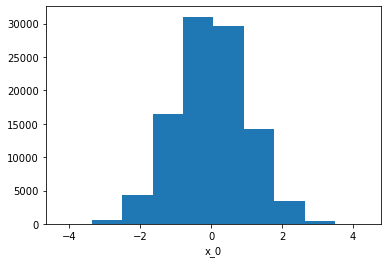

In [33]:
plt.hist(x);
plt.xlabel("x_0");

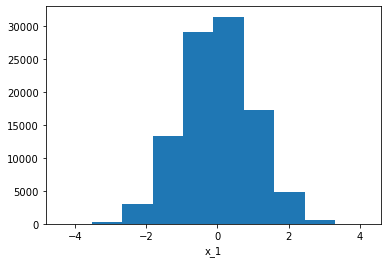

In [34]:
plt.hist(x2);
plt.xlabel("x_1");

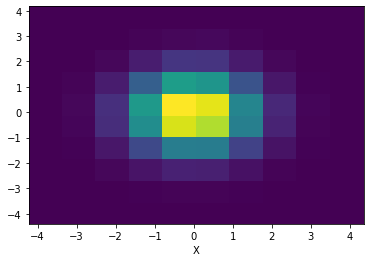

In [35]:
plt.hist2d(x, x2);
plt.xlabel("X");

In [36]:
Y = encoder_2d.predict(X);

(-5, 5)

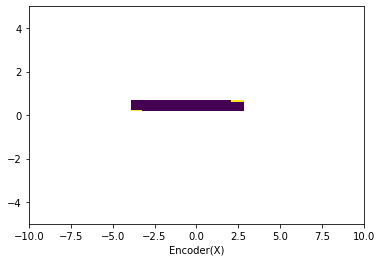

In [46]:
plt.hist2d(Y[0], Y[1]);
plt.xlabel("Encoder(X)");
plt.xlim(-10, 10)
plt.ylim(-5, 5)

(-10, 10)

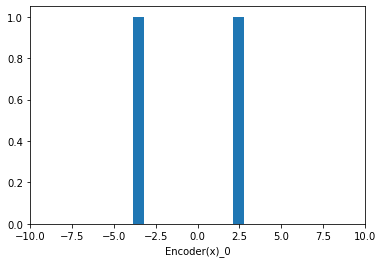

In [42]:
plt.hist(Y[0]);
plt.xlabel("Encoder(x)_0");
plt.xlim(-10, 10)

(-10, 10)

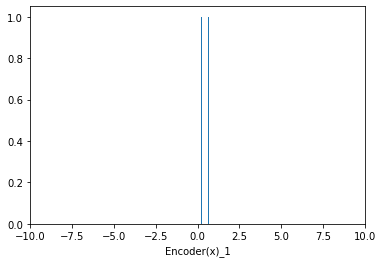

In [43]:
plt.hist(Y[1]);
plt.xlabel("Encoder(x)_1");
plt.xlim(-10, 10)